## PART-A (BUC Algorithm)

**Headers**

In [142]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import groupby


**Load the excel file**

In [143]:
df = pd.read_excel('master.xlsx')

**Data Preparation**

In [144]:
def drop_column(df, column_name):
    """
    Drop a column from the DataFrame.
    """
    if column_name in df.columns:
        df.drop(columns=[column_name], inplace=True)

def discretize_column(df, column_name, bins, labels):
    """
    Discretize a numerical column into categories and assign labels.
    """
    if column_name in df.columns:
        df[column_name] = pd.cut(df[column_name], bins=bins, labels=labels)

def prepareData(df):
    population_bins = [0, df["population"].quantile(0.25), df["population"].quantile(0.75), df["population"].max()]
    population_labels = ["Low_population", "Medium_population", "High_population"]

    suicides_bins = [-1] + list(range(0, int(df["suicides_no"].quantile(0.75) + 10), 10)) + [int(df["suicides_no"].max()) + 1]
    suicides_labels = [f"{suicides_bins[i] + 1}-{suicides_bins[i + 1]}" for i in range(len(suicides_bins) - 1)]
    suicides_labels[-1] = f">{suicides_bins[-2]}"

    # Define discretization bins and labels for gdp_for_year ($)
    gdp_year_bins = [0, df[" gdp_for_year ($) "].quantile(0.25), df[" gdp_for_year ($) "].quantile(0.75), df[" gdp_for_year ($) "].max()]
    gdp_year_labels = ["Low_income_country", "Medium_income_country", "High_income_country"]

    # Define discretization bins and labels for gdp_per_capita ($)
    gdp_capita_bins = list(range(0, int(df["gdp_per_capita ($)"].quantile(0.75) + 1000), 1000)) + [int(df["gdp_per_capita ($)"].max())]
    gdp_capita_labels = [f"{gdp_capita_bins[i]}-{gdp_capita_bins[i + 1]}" for i in range(len(gdp_capita_bins) - 1)]
    gdp_capita_labels[-1] = f">{gdp_capita_bins[-2]}"
    print(gdp_capita_labels[-1])
    
    # Drop unnecessary columns
    drop_column(df, "country-year")
    drop_column(df, "suicides/100k pop")
    drop_column(df, "HDI for year")

    # Perform discretization
    discretize_column(df, "population", population_bins, population_labels)
    discretize_column(df, "suicides_no", suicides_bins, suicides_labels)
    discretize_column(df, " gdp_for_year ($) ", gdp_year_bins, gdp_year_labels)
    discretize_column(df, "gdp_per_capita ($)", gdp_capita_bins, gdp_capita_labels)

    return df


In [145]:
outputRec=[]
def Aggregate(input):
    outputRec.append(input)


In [146]:
df = prepareData(df)

>25000


In [147]:
def get_unique_value_counts(data):
    """
    Compute the counts of unique values in the first column of data.

    Args:
    data (numpy.ndarray): The input data containing at least one column.

    Returns:
    list of int: A list of counts corresponding to each unique value.
    """
    unique_values, counts = np.unique(data[:, 0], return_counts=True)
    return list(counts)

def compute_buc_patterns(data, minsup):
    """
    Compute patterns with minimum support using the BUC algorithm.

    Args:
    data (numpy.ndarray): The input data as a 2D array.
    minsup (int): The minimum support threshold for patterns.

    Returns:
    pandas.DataFrame: A DataFrame containing patterns that meet the minimum support threshold.
    """
    patterns = []

    def recursive_compute(data, current_pattern=[]):
        if data.shape[1] == 0:
            patterns.append(current_pattern + [len(data)])
            return

        sorted_data = data[data[:, 0].argsort()]
        data_counts = get_unique_value_counts(sorted_data)
        i = 0

        for support in data_counts:
            if support >= minsup:
                new_pattern = current_pattern + [sorted_data[i, 0]]
                recursive_compute(sorted_data[i:i+support, 1:], new_pattern)
            i += support

        new_pattern = current_pattern + ["ALL"]
        recursive_compute(data[:, 1:], new_pattern)

    recursive_compute(data, [])

    result_df = pd.DataFrame(patterns, columns=list(df.columns) + ["count_buc"])
    return result_df

min_support_threshold = 100
result_patterns_df = compute_buc_patterns(df.values, min_support_threshold)

In [148]:
print("BUC Algorithm result with minimum support 100")
result_patterns_df

BUC Algorithm result with minimum support 100


,country,year,sex,age,suicides_no,population,gdp_for_year ($),gdp_per_capita ($),generation,count_buc
0,Albania,ALL,female,ALL,ALL,Medium_population,ALL,ALL,ALL,110
1,Albania,ALL,female,ALL,ALL,ALL,Low_income_country,ALL,ALL,102
2,Albania,ALL,female,ALL,ALL,ALL,ALL,ALL,ALL,132
3,Albania,ALL,male,ALL,ALL,Medium_population,ALL,ALL,ALL,110
4,Albania,ALL,male,ALL,ALL,ALL,Low_income_country,ALL,ALL,102
...,...,...,...,...,...,...,...,...,...,...
9420,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,Generation X,6408
9421,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,Generation Z,1470
9422,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,Millenials,5844
9423,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,Silent,6364


In [149]:
df = df.astype(str)

**BUC Algorithm**

In [150]:
num_col = df.shape[1]
minsup = 100
def BUC(dataFrame, begin, end):
    if end - num_col >= 0:
        return
   
    column = dataFrame.columns[end]
    count_dataFrame = dataFrame.groupby(column)[column].count().reset_index(name='count').sort_values(by='count', ascending=False)

    for i in range(len(count_dataFrame)):
        if count_dataFrame.iloc[i, 1] >= minsup:
            value = count_dataFrame.iloc[i, 0]
           
            temp_dataFrame = dataFrame.loc[dataFrame[dataFrame.columns[end]] == value, dataFrame.columns[begin:end + 1]].head(1)
            temp_dataFrame = ' ~ '.join(temp_dataFrame.iloc[0].astype(str))

            next_dataFrame = dataFrame[dataFrame[dataFrame.columns[end]] == value]
            BUC(next_dataFrame, begin, end + 1)

In [151]:
sup = []
runtime = []

for i in range(100, 1000, 100):
    minsup = i

    initialTime = time.time()
    s = 0
   
    n = 1 # Number of iterations to average on
    for idx in range(n):
        for j in range(num_col):
            BUC(df, j, j)
        s += minsup
       
    finalTime = time.time()
   
    sup.append(s/n)
    runtime.append(finalTime - initialTime)

**Plot of minsup vs. runtime**

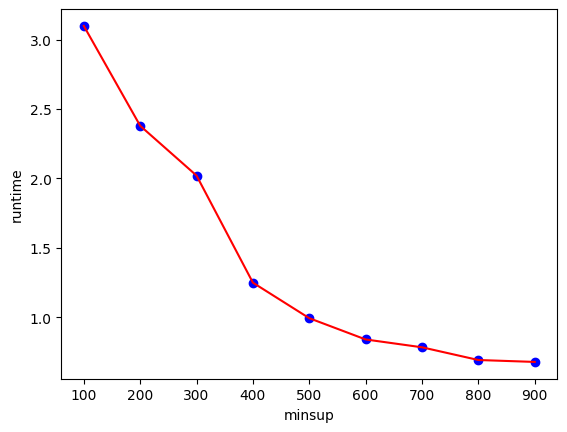

In [152]:
plt.plot(sup, runtime, color='red', linestyle='-')
plt.scatter(sup, runtime, color='blue', marker='o', label='Data Points')
plt.xlabel('minsup')
plt.ylabel('runtime')
plt.show()

We can observe that as the value of minsup is increasing the run time is decreasing gradually.

When we increase the minimum support threshold (minsup), then we can see an effective reduction in the number of patterns or partitions that need to be processed, which can lead to a decrease in runtime. This is because the algorithm becomes more selective in which patterns it considers, and it prunes or skips over partitions that don't meet the minimum support criteria.

In [153]:
# Calculate memory usage in KB
totalKBMemory = df.memory_usage().sum() / 1024

# Change main_memory_kb from 100 to 4000 in steps of 300
# Calculate the time taken for each main_memory_kb
# Plot the graph of time vs main_memory_kb
listMemory = []
listTime = []

for mainKBMemory in range(100, 4000, 300):
    number_of_pages = int(totalKBMemory / mainKBMemory)
    initialTime = time.time()

    # Create pages and run BUC on each page
    for i in range(number_of_pages):
        dataFrame = df.iloc[i * num_col:(i + 1) * num_col, :]
        for j in range(num_col):
            BUC(dataFrame, j, j)

    finalTime = time.time()
    listTime.append(finalTime - initialTime)
    listMemory.append(mainKBMemory)

**Plot of allotted memory vs. runtime**

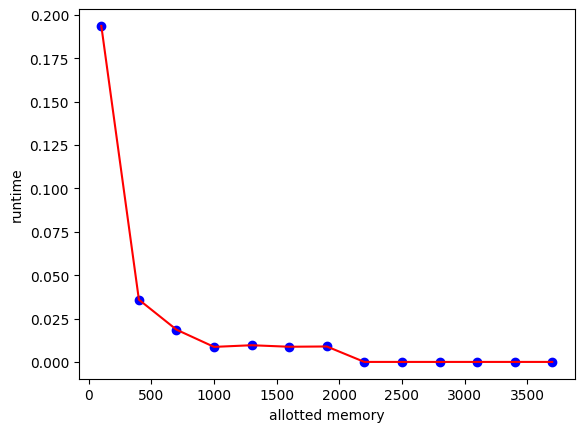

In [154]:
plt.plot(listMemory, listTime, color='red')
plt.scatter(listMemory, listTime, color='blue')
plt.xlabel('allotted memory')
plt.ylabel('runtime')
plt.show()

Increasing the allocated memory leads to a decrease in runtime for the paged version of the Bottom-Up Computation algorithm. This improvement in runtime is due to the fact that with more memory available, the algorithm can load larger portions of the data into memory at once, reducing the need for frequent disk I/O operations, which are typically slower compared to in-memory operations.

## PART-B (AOI)

**Attribute Oriented Induction involves**

**1) Attribute Removal**

**2) Attribute Generalization**

**Final outcome is summary of the dataset**

**Load the excel file**

In [155]:
data_frame = pd.read_excel('cleaned_data.xlsx')

**1)Attribute Removal**

In [156]:
#Dropping unnecessary columns 
new_df = data_frame.drop(columns=["Property_Name","Property_id","Project_URL","builder_id","Builder_name","City_id","Locality_ID","Locality_Name","Longitude","Latitude","Sub_urban_ID","Sub_urban_name","description","listing_domain_score","Listing_Category","is_Apartment","is_commercial_Listing","is_studio","is_plot","is_RERA_registered","is_PentaHouse","is_ready_to_move"], axis=1)
new_df.info

<bound method DataFrame.info of        Property_type     Property_status Price_per_unit_area     Posted_On  \
0          Apartment  Under Construction                4285     1 day ago   
1          Apartment  Under Construction                7000    2 days ago   
2          Apartment       Ready to move                5752    2 days ago   
3          Apartment       Ready to move                2486    5 days ago   
4          Apartment  Under Construction                5324    8 days ago   
...              ...                 ...                 ...           ...   
143703     Apartment  Under Construction                9826  4 months ago   
143704     Apartment  Under Construction                8568  4 months ago   
143705     Apartment  Under Construction                9861  4 months ago   
143706     Apartment  Under Construction                8813  4 months ago   
143707     Apartment  Under Construction                9859  4 months ago   

       Property_building_status

**2)Attribute Generalization**

In [157]:
def own_logic(cell):
    if "days" in cell:
        return 1
    if "minutes" in cell:
        return 1
    if "month" in cell:
        if cell[0] == "a":
            return 2
        return int(cell[0])
    if "years" in cell:
        if cell[0] == "a":
            return 12
        return int(cell[0])*12
    else:
        return 1

In [158]:
new_df["Posted_On"]=new_df["Posted_On"].apply(str)
new_df["Posted_On"]=new_df["Posted_On"].apply(own_logic)
new_df['Price']=pd.to_numeric(new_df['Price'].str.replace(',',''))
percentiles = [25, 75]
percentile_values = new_df['Price'].quantile([p / 100 for p in percentiles])

In [159]:
def categorize_price_percentile(price):
    if price <= percentile_values.iloc[0]:
        return 'Low_Budget'
    elif price <= percentile_values.iloc[1] and price >percentile_values.iloc[0]:
        return 'Medium_Budget'
    else:
        return 'High_Budget'

new_df['Budget_Category'] = new_df['Price'].apply(categorize_price_percentile)

In [160]:
new_df['Size'] = pd.to_numeric(new_df['Size'].str.replace(' sq ft', '').str.replace(',', ''))
def convert_to_numeric(value):
    if isinstance(value, str):
        return pd.to_numeric(value.replace(',', ''), errors='coerce')
    return value

new_df['Price_per_unit_area'] = new_df['Price_per_unit_area'].apply(convert_to_numeric)
new_df["Price_per_unit_area"].describe()

count    143708.000000
mean      10664.535600
std        8512.886153
min         104.000000
25%        5256.000000
50%        7938.000000
75%       13333.000000
max      171969.000000
Name: Price_per_unit_area, dtype: float64

In [161]:
result = []

for x in range(0, 2000000, 5000):
    filtered_df = new_df[(new_df["Price_per_unit_area"] >= x) & (new_df["Price_per_unit_area"] < (x + 5000))]
    if not filtered_df.empty:
        for index, row in filtered_df.iterrows():
            data = row.tolist()
            data.append(f"{x}-{x+5000}")
            result.append(data)

result_df = pd.DataFrame(result, columns=new_df.columns.tolist() + ["Price_per_unit_area_bins"])

In [162]:
new_df=result_df
#creating bins for month ranges 
bin_edges = list(range(0, 37, 4)) 
bin_labels = [f'{start}-{start+3}' for start in bin_edges[:-1]]
new_df['Posted_month_bin'] = pd.cut(new_df['Posted_On'], bins=bin_edges, labels=bin_labels, include_lowest=True)
#dropping non active rows
drop_rows = new_df[(new_df['Property_building_status'] != 'ACTIVE') ].index
new_df.drop(drop_rows, inplace = True)
new_df=new_df.drop(columns=["Price_per_unit_area","Price","Posted_On","Property_building_status"],axis=1)

**Final Dataset**

In [163]:
new_df

,Property_type,Property_status,City_name,No_of_BHK,Size,is_furnished,Budget_Category,Price_per_unit_area_bins,Posted_month_bin
0,Apartment,Under Construction,Ahmedabad,3 BHK,1750,Unfurnished,Medium_Budget,0-5000,0-3
1,Apartment,Ready to move,Ahmedabad,2 BHK,918,Unfurnished,Low_Budget,0-5000,0-3
2,Apartment,Under Construction,Ahmedabad,2 BHK,1305,Unfurnished,Low_Budget,0-5000,0-3
3,Apartment,Under Construction,Ahmedabad,2 BHK,1485,Unfurnished,Low_Budget,0-5000,0-3
4,Apartment,Under Construction,Ahmedabad,3 BHK,1495,Unfurnished,Medium_Budget,0-5000,0-3
...,...,...,...,...,...,...,...,...,...
143703,Apartment,Ready to move,Mumbai,5 BHK,4122,Unfurnished,High_Budget,150000-155000,8-11
143704,Apartment,Ready to move,Mumbai,5 BHK,2826,Unfurnished,High_Budget,150000-155000,8-11
143705,Apartment,Ready to move,Mumbai,2 BHK,1100,Semi-Furnished,High_Budget,150000-155000,0-3
143706,Apartment,Ready to move,Ahmedabad,4 BHK,1163,Furnished,High_Budget,170000-175000,4-7


**Summarization of whole generalized data**

In [164]:
grouped = new_df.groupby(['Property_type', 'Property_status']).size().reset_index(name='Count')
pivot_table = pd.pivot_table(grouped, values='Count', index='Property_type', columns='Property_status', fill_value=0)
pivot_table = pivot_table.rename(columns={'Under Construction': 'Under Construction', 'Ready to move': 'Ready to move'})
pivot_table

Property_status,Ready to move,Under Construction
Property_type,,
Apartment,70419,60408
Independent Floor,1503,161
Independent House,527,353
Residential Plot,5111,1706
Villa,1952,1398


In [165]:
grouped = new_df.groupby(['City_name', 'Property_type', 'Property_status']).size().reset_index(name='Count')
pivot_table = pd.pivot_table(grouped, values='Count', index='City_name', columns=['Property_type', 'Property_status'], fill_value=0)
pivot_table.reset_index(inplace=True)
pivot_table

Property_type    City_name     Apartment                    Independent Floor  \
Property_status            Ready to move Under Construction     Ready to move   
0                Ahmedabad          3574               2580                22   
1                Bangalore          8958               9723                20   
2                  Chennai          5062               4062                10   
3                    Delhi          5771                277              1240   
4                Hyderabad          2549               4053                 4   
5                  Kolkata          4236               7275                42   
6                  Lucknow           543                563                18   
7                   Mumbai         39726              31875               147   

Property_type                      Independent House                     \
Property_status Under Construction     Ready to move Under Construction   
0                                1               101                  7   
1                                4                54                 67   
2                                0                95                 60   
3                              102                52                  0   
4                                7                41                 84   
5                               12                27                102   
6                               12                94                 18   
7                               23                63                 15   

Property_type   Residential Plot                            Villa  \
Property_status    Ready to move Under Construction Ready to move   
0                             61                 24           208   
1                            739                350           621   
2                           2664                618           474   
3                             27                  0             7   
4                           1265                542           306   
5                            170                 98            46   
6                            132                 64           168   
7                             53                 10           122   

Property_type                       
Property_status Under Construction  
0                               26  
1                              438  
2                              346  
3                                0  
4                              271  
5                              203  
6                               78  
7                               36

In [166]:
grouped = new_df.groupby(['Budget_Category', 'City_name','Property_type', 'Property_status']).size().reset_index(name='Count')
pivot_table = pd.pivot_table(grouped, values='Count', index='Budget_Category', columns=['City_name','Property_type', 'Property_status'], fill_value=0)
pivot_table.reset_index(inplace=True)
pivot_table

City_name       Budget_Category     Ahmedabad                     \
Property_type                       Apartment                      
Property_status                 Ready to move Under Construction   
0                   High_Budget           632                579   
1                    Low_Budget          1220                671   
2                 Medium_Budget          1722               1330   

City_name                                                               \
Property_type   Independent Floor                    Independent House   
Property_status     Ready to move Under Construction     Ready to move   
0                               3                  1                70   
1                              11                  0                10   
2                               8                  0                21   

City_name                                                               \
Property_type                      Residential Plot                      
Property_status Under Construction    Ready to move Under Construction   
0                                5               28                  5   
1                                0               21                 10   
2                                2               12                  9   

City_name                      ...        Mumbai                     \
Property_type           Villa  ...     Apartment                      
Property_status Ready to move  ... Ready to move Under Construction   
0                         148  ...         13166               8986   
1                          13  ...          7806               6847   
2                          47  ...         18754              16042   

City_name                                                               \
Property_type   Independent Floor                    Independent House   
Property_status     Ready to move Under Construction     Ready to move   
0                              21                  8                34   
1                             112                 10                11   
2                              14                  5                18   

City_name                                                               \
Property_type                      Residential Plot                      
Property_status Under Construction    Ready to move Under Construction   
0                                5                1                  8   
1                                8               49                  0   
2                                2                3                  2   

City_name                                         
Property_type           Villa                     
Property_status Ready to move Under Construction  
0                          62                 13  
1                          40                 10  
2                          20                 13  

[3 rows x 77 columns]

In [167]:
grouped = new_df.groupby(['Budget_Category', 'City_name','Property_type', 'Property_status']).size().reset_index(name='Count')
pivot_table = pd.pivot_table(grouped, values='Count', index=['Budget_Category', 'City_name', 'Property_type'], columns='Property_status', fill_value=0)
pivot_table = pivot_table.stack().reset_index()
pivot_table.columns = ['Budget_Category', 'City_name', 'Property_type', 'Property_status', 'Count']
pivot_table

,Budget_Category,City_name,Property_type,Property_status,Count
0,High_Budget,Ahmedabad,Apartment,Ready to move,632
1,High_Budget,Ahmedabad,Apartment,Under Construction,579
2,High_Budget,Ahmedabad,Independent Floor,Ready to move,3
3,High_Budget,Ahmedabad,Independent Floor,Under Construction,1
4,High_Budget,Ahmedabad,Independent House,Ready to move,70
...,...,...,...,...,...
229,Medium_Budget,Mumbai,Independent House,Under Construction,2
230,Medium_Budget,Mumbai,Residential Plot,Ready to move,3
231,Medium_Budget,Mumbai,Residential Plot,Under Construction,2
232,Medium_Budget,Mumbai,Villa,Ready to move,20


In [168]:
new_df["Property_type"].unique()
counts = new_df['is_furnished'].value_counts().reset_index()
counts.columns = ['Furnishing Type', 'Count']
print(counts)

  Furnishing Type   Count
0     Unfurnished  104298
1  Semi-Furnished   32973
2       Furnished    6267


In [169]:
counts = new_df.groupby(['City_name', 'Property_type', 'No_of_BHK']).agg(
    SemiFurnished_Count=('is_furnished', lambda x: (x == 'Semi-Furnished').sum()),
    Furnished_Count=('is_furnished', lambda x: (x == 'Furnished').sum()),
    Unfurnished_Count=('is_furnished', lambda x: (x == 'Unfurnished').sum()),
    Ready_to_move=('Property_status',lambda x:(x=="Ready to move").sum()),
).reset_index()
counts

,City_name,Property_type,No_of_BHK,SemiFurnished_Count,Furnished_Count,Unfurnished_Count,Ready_to_move
0,Ahmedabad,Apartment,1 BHK,85,37,137,225
1,Ahmedabad,Apartment,1 RK,0,4,13,13
2,Ahmedabad,Apartment,2 BHK,417,294,1217,1345
3,Ahmedabad,Apartment,3 BHK,357,392,1995,1417
4,Ahmedabad,Apartment,4 BHK,88,118,837,502
...,...,...,...,...,...,...,...
228,Mumbai,Villa,2 BHK,23,1,14,29
229,Mumbai,Villa,3 BHK,12,6,19,21
230,Mumbai,Villa,4 BHK,17,3,15,32
231,Mumbai,Villa,5 BHK,16,4,5,25


In [170]:
counts = new_df.groupby(['City_name']).agg(
    Apartment=('Property_type', lambda x: (x == 'Apartment').sum()),
    Independent_House=('Property_type', lambda x: (x == 'Independent House').sum()),
    Villa=('Property_type', lambda x: (x == 'Villa').sum()),
    Independent_Floor=('Property_type',lambda x:(x=="Independent Floor").sum()),
    Residential_Plot=('Property_type',lambda x:(x=="Residential Plot").sum())
).reset_index()
counts

,City_name,Apartment,Independent_House,Villa,Independent_Floor,Residential_Plot
0,Ahmedabad,6154,108,234,23,85
1,Bangalore,18681,121,1059,24,1089
2,Chennai,9124,155,820,10,3282
3,Delhi,6048,52,7,1342,27
4,Hyderabad,6602,125,577,11,1807
5,Kolkata,11511,129,249,54,268
6,Lucknow,1106,112,246,30,196
7,Mumbai,71601,78,158,170,63


In [171]:
counts = new_df.groupby(['Budget_Category', 'City_name']).agg(
    Apartment=('Property_type', lambda x: (x == 'Apartment').sum()),
    Independent_House=('Property_type', lambda x: (x == 'Independent House').sum()),
    Villa=('Property_type', lambda x: (x == 'Villa').sum()),
    Independent_Floor=('Property_type',lambda x:(x=="Independent Floor").sum()),
    Residential_Plot=('Property_type',lambda x:(x=="Residential Plot").sum()),
    SemiFurnished_Count=('is_furnished', lambda x: (x == 'Semi-Furnished').sum()),
    Furnished_Count=('is_furnished', lambda x: (x == 'Furnished').sum()),
    Unfurnished_Count=('is_furnished', lambda x: (x == 'Unfurnished').sum()),
    Ready_to_move=('Property_status',lambda x:(x=="Ready to move").sum()),
).reset_index()
counts

,Budget_Category,City_name,Apartment,Independent_House,Villa,Independent_Floor,Residential_Plot,SemiFurnished_Count,Furnished_Count,Unfurnished_Count,Ready_to_move
0,High_Budget,Ahmedabad,1211,75,156,4,33,147,258,1074,881
1,High_Budget,Bangalore,3272,70,747,8,160,713,103,3441,2244
2,High_Budget,Chennai,1108,14,179,4,278,167,37,1379,1055
3,High_Budget,Delhi,3089,27,7,273,4,2714,394,292,3258
4,High_Budget,Hyderabad,1060,29,391,2,93,225,98,1252,785
5,High_Budget,Kolkata,1140,61,33,2,0,106,51,1079,527
6,High_Budget,Lucknow,40,3,14,2,6,25,6,34,36
7,High_Budget,Mumbai,22152,39,75,29,9,6043,1579,14682,13284
8,Low_Budget,Ahmedabad,1891,10,14,11,31,378,204,1375,1275
9,Low_Budget,Bangalore,2973,5,25,3,390,533,93,2770,1833
